In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [7]:
poke = pd.read_csv('pokemon.csv')

In [9]:
poke.head(5)

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


##### Гипотезы


#### 0. Описание датасета

Типы данных в датафрейме

In [11]:
set(poke.dtypes)

{dtype('int64'), dtype('float64'), dtype('O')}

In [14]:
set(poke.isna().all())

{False}

#### 1. Pandas

<Axes: >

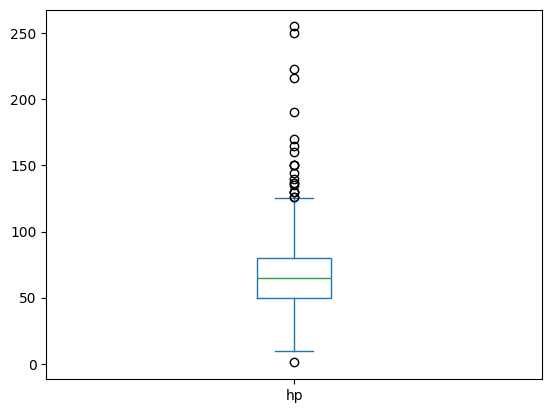

In [22]:
poke['hp'].plot.box()


In [20]:
poke.describe

<bound method NDFrame.describe of                        abilities  against_bug  against_dark  against_dragon  \
0    ['Overgrow', 'Chlorophyll']         1.00           1.0             1.0   
1    ['Overgrow', 'Chlorophyll']         1.00           1.0             1.0   
2    ['Overgrow', 'Chlorophyll']         1.00           1.0             1.0   
3       ['Blaze', 'Solar Power']         0.50           1.0             1.0   
4       ['Blaze', 'Solar Power']         0.50           1.0             1.0   
..                           ...          ...           ...             ...   
796              ['Beast Boost']         0.25           1.0             0.5   
797              ['Beast Boost']         1.00           1.0             0.5   
798              ['Beast Boost']         2.00           0.5             2.0   
799              ['Prism Armor']         2.00           2.0             1.0   
800               ['Soul-Heart']         0.25           0.5             0.0   

     against_elec